In [1]:
import warnings
warnings.filterwarnings('ignore')


#loading the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
#from sklearn.cross_validation import KFold   #For K-fold cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn import model_selection

In [2]:
train_df= pd.read_csv("../data/loan_prediction_train.csv")
test_df = pd.read_csv("../data/loan_prediction_test.csv")

In [3]:
train_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
print('loans data has {0} rows and {1} columns'.format(train_df.shape[0],train_df.shape[1]))

loans data has 614 rows and 13 columns


In [5]:
#summary of numerical variables
train_df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


The Loan amount,loans_amount_term and credit history has missing values

* LoanAmount has (614 – 592) 22 missing values.
* Loan_Amount_Term has (614 – 600) 14 missing values.
* Credit_History has (614 – 564) 50 missing values.
* We can also look that about 84% applicants have a credit_history. How? The mean of Credit_History field is 0.84 (Remember, Credit_History has value 1 for those who have a credit history and 0 otherwise)
* The ApplicantIncome distribution seems to be in line with expectation. Same with CoapplicantIncome


In [6]:
train_df['Property_Area'].value_counts()

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64

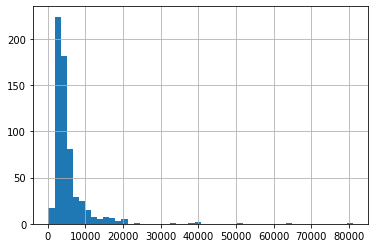

In [7]:
#distribution analysis
train_df['ApplicantIncome'].hist(bins=50)

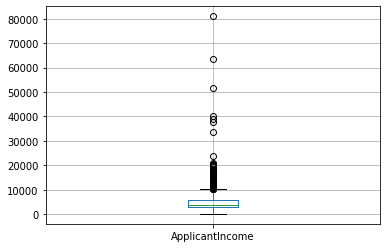

In [8]:
train_df.boxplot(column='ApplicantIncome')

This confirms the presence of a lot of outliers/extreme values. This can be attributed to the income disparity in the society. Part of this can be driven by the fact that we are looking at people with different education levels. Let us segregate them by Education:

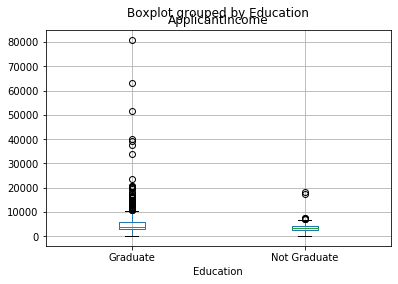

In [9]:
train_df.boxplot(column='ApplicantIncome', by='Education')

We can see that there is no substantial different between the mean income of graduate and non-graduates. But there are a higher number of graduates with very high incomes, which are appearing to be the outliers.

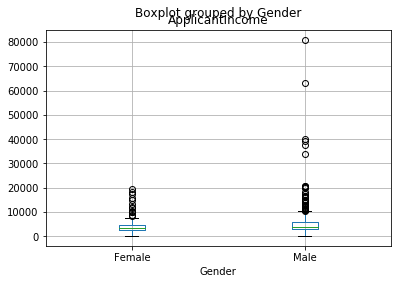

In [10]:
train_df.boxplot(column='ApplicantIncome', by='Gender')

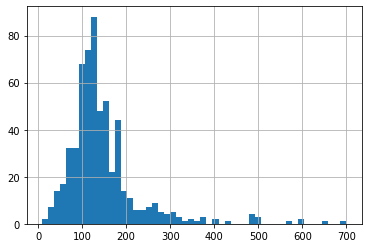

In [11]:
train_df['LoanAmount'].hist(bins=50)

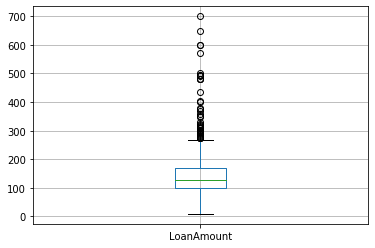

In [12]:
train_df.boxplot(column='LoanAmount')

In [13]:
#function for checking missing values per column

#Create a new function:
def num_missing(x):
    return sum(x.isnull())

#Applying per column:
print ("Missing values per column in training set:")
print(train_df.apply(num_missing, axis=0)) #axis=0 defines that function is to be applied on each column
print("Missing values per column in test set:")
print(test_df.apply(num_missing,axis =0))

Missing values per column in training set:
Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64
Missing values per column in test set:
Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64


In [14]:
#creation of pivot table
temp1 = train_df['Credit_History'].value_counts(ascending=True)

print('Frequency Table for Credit History:')
print (temp1)

temp2 = train_df.pivot_table(values='Loan_Status',index=['Credit_History'],aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())
print('\nProbility of getting loan for each Credit History class:')
print(temp2)

Frequency Table for Credit History:
0.0     89
1.0    475
Name: Credit_History, dtype: int64

Probility of getting loan for each Credit History class:
                Loan_Status
Credit_History             
0.0                0.078652
1.0                0.795789


Text(0.5, 1.0, 'Probability of getting loan by credit history')

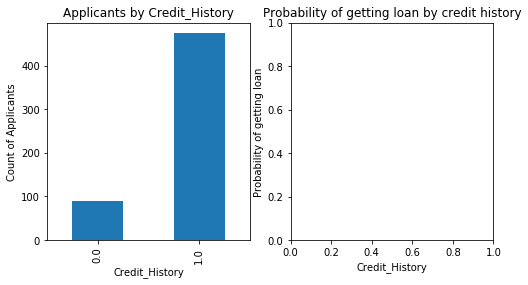

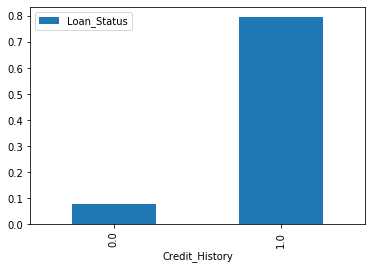

In [15]:
#visualization

fig= plt.figure(figsize=(8,4))
axis1= fig.add_subplot(121)
axis1.set_xlabel('Credit_History')
axis1.set_ylabel('Count of Applicants')
axis1.set_title("Applicants by Credit_History")
temp1.plot(kind='bar')

axis2 = fig.add_subplot(122)
temp2.plot(kind = 'bar')
axis2.set_xlabel('Credit_History')
axis2.set_ylabel('Probability of getting loan')
axis2.set_title("Probability of getting loan by credit history")

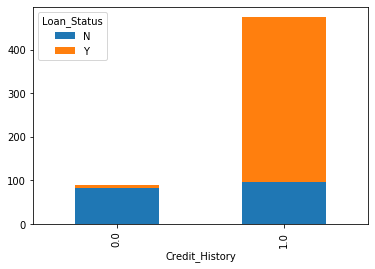

In [16]:
#alternatively, visualizing via stacked chart
temp3 = pd.crosstab(train_df['Credit_History'], train_df['Loan_Status'])
temp3.plot(kind='bar',stacked = True)

In [17]:
#imputing missing values
#df['LoanAmount'].fillna(df['LoanAmount'].mean(), inplace=True)

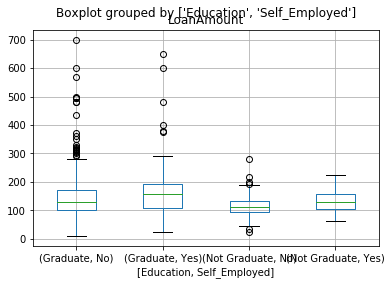

In [18]:
train_df.boxplot(column='LoanAmount', by=['Education','Self_Employed'])

In [19]:
print(train_df['Self_Employed'].value_counts())
print(test_df['Self_Employed'].value_counts())


No     500
Yes     82
Name: Self_Employed, dtype: int64
No     307
Yes     37
Name: Self_Employed, dtype: int64


Since ~86% values are "No", it is safe to impute the missing values as "No" as there is a high probability of success. This can be done using the following code:

In [20]:
train_df['Self_Employed'].fillna('No',inplace=True)
test_df['Self_Employed'].fillna('No',inplace = True)

Now, we will create a Pivot table, which provides us median values for all the groups of unique values of Self_Employed and Education features. Next, we define a function, which returns the values of these cells and apply it to fill the missing values of loan amount:

In [21]:
table = train_df.pivot_table(values = 'LoanAmount', index = 'Self_Employed',
                       columns = 'Education',aggfunc =np.median)
#define function to return value of this pivot_table 
def fage(x):
    return table.loc[x['Self_Employed'],x['Education']]

#Replace missing values in train and test set

train_df['LoanAmount'].fillna(train_df[train_df['LoanAmount'].isnull()].apply(fage,axis=1),inplace=True)
test_df['LoanAmount'].fillna(test_df[test_df['LoanAmount'].isnull()].apply(fage,axis=1),inplace=True)

**How to treat for extreme values in distribution of LoanAmount and ApplicantIncome?**

Let's analyze LoanAmount first. Since the extreme values are practically possible, i.e. some people might apply for high value loans due to specific needs. So instead of treating them as outliers, let's try a log transformation to nullify their effect:

Look at the histogram:


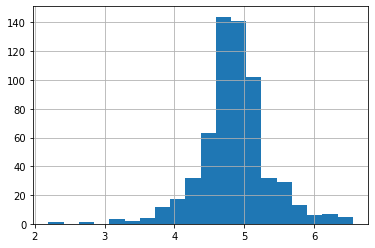

In [22]:
train_df['LoanAmount_log']= np.log(train_df['LoanAmount'])
print('Look at the histogram:')
train_df['LoanAmount_log'].hist(bins=20)

In [23]:
test_df['LoanAmount_log'] = np.log(test_df['LoanAmount'])

Coming to ApplicantIncome. One intuition can be that some applicants have lower income but strong support Co-applicants. So it might be a good idea to combine both incomes as total income and take a log transformation of the same.

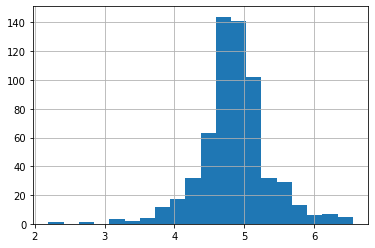

In [24]:
train_df['Total_Income']= train_df['ApplicantIncome']+ train_df['CoapplicantIncome']
train_df['TotalIncome_log'] = np.log(train_df['Total_Income'])
train_df['LoanAmount_log'].hist(bins=20)

In [25]:
test_df['Total_Income'] = test_df['ApplicantIncome'] + test_df['CoapplicantIncome']
test_df['TotalIncome_log'] = np.log(test_df['Total_Income'])

In [26]:
train_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,LoanAmount_log,Total_Income,TotalIncome_log
0,LP001002,Male,No,0,Graduate,No,5849,0.0,130.0,360.0,1.0,Urban,Y,4.867534,5849.0,8.674026
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,4.852030,6091.0,8.714568
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,4.189655,3000.0,8.006368
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,4.787492,4941.0,8.505323
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,4.948760,6000.0,8.699515


In [27]:
test_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,LoanAmount_log,Total_Income,TotalIncome_log
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban,4.700480,5720,8.651724
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban,4.836282,4576,8.428581
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban,5.337538,6800,8.824678
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban,4.605170,4886,8.494129
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban,4.356709,3276,8.094378


In [28]:
#Imputation
train_df['Loan_Amount_Term'].fillna(train_df['Loan_Amount_Term'].mean(),inplace = True)
test_df['Loan_Amount_Term'].fillna(test_df['Loan_Amount_Term'].mean(),inplace = True)

#Credit_History
train_df['Credit_History'].fillna(1, inplace = True)
test_df['Credit_History'].fillna(1, inplace = True)

#Married
train_df['Married'].fillna('Yes', inplace = True)
test_df['Married'].fillna('Yes', inplace = True)

#Gender
train_df['Gender'].fillna('Male', inplace = True)
test_df['Gender'].fillna('Male',inplace = True)

#Dependents
train_df['Dependents'].fillna('0', inplace = True)
test_df['Dependents'].fillna('0', inplace = True)

Debt_Income_Ratio

In [29]:
train_df['Debt_Income_Ratio'] = train_df['Total_Income']/train_df['LoanAmount']
test_df['Debt_Income_Ratio'] = test_df['Total_Income']/test_df['LoanAmount']

In [30]:
#Label encoding the categorical variables
cat_columns = ['Gender','Married','Dependents','Education',
               'Self_Employed','Property_Area','Loan_Status']

le = LabelEncoder()
for i in cat_columns:
    train_df[i] = le.fit_transform(train_df[i])
    if(i!= 'Loan_Status'):
        test_df[i]=le.fit_transform(test_df[i])

In [31]:
test_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,LoanAmount_log,Total_Income,TotalIncome_log,Debt_Income_Ratio
0,LP001015,1,1,0,0,0,5720,0,110.0,360.0,1.0,2,4.700480,5720,8.651724,52.000000
1,LP001022,1,1,1,0,0,3076,1500,126.0,360.0,1.0,2,4.836282,4576,8.428581,36.317460
2,LP001031,1,1,2,0,0,5000,1800,208.0,360.0,1.0,2,5.337538,6800,8.824678,32.692308
3,LP001035,1,1,2,0,0,2340,2546,100.0,360.0,1.0,2,4.605170,4886,8.494129,48.860000
4,LP001051,1,0,0,1,0,3276,0,78.0,360.0,1.0,2,4.356709,3276,8.094378,42.000000


Modelling

In [32]:
X = train_df.drop(["Loan_ID","Total_Income","LoanAmount","ApplicantIncome","CoapplicantIncome","Loan_Status"], axis=1)
y = train_df.Loan_Status

In [33]:
seed= 1111
models = []
accuracy = 'accuracy'
models.append(('LR', LogisticRegression()))
models.append(('RF', RandomForestClassifier()))
models.append(('DF', DecisionTreeClassifier()))
models.append(('XGB',XGBClassifier()))

#evaluate each model in turn
results = []
names = []

for name, model in models:
    kfold = model_selection.KFold(n_splits = 10, random_state = seed)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring = accuracy)
    results.append(cv_results)
    names.append(name)
    msg = "%s:%f (%f)" % (name,cv_results.mean(), cv_results.std())
    print(msg)

LR:0.809598 (0.035573)
RF:0.786832 (0.042346)
DF:0.690534 (0.043724)
XGB:0.798096 (0.022703)


In [34]:
model_LR = LogisticRegression()
model_LR=model_LR.fit(X,y)

#model_LR.save_model('../models/Logistic_model.txt')

In [35]:
model_XGB = XGBClassifier()
model_XGB=model_XGB.fit(X,y)
model_XGB.save_model('../models/Xgboost_model.txt')

In [36]:
X_test_df = test_df.drop(["Loan_ID","Total_Income","LoanAmount","ApplicantIncome","CoapplicantIncome"], axis=1)

test_set_pred = model_LR.predict(X_test_df)

In [37]:
xgb_pred=model_LR.predict(X_test_df)

In [38]:
sample_submission = {'Loan_ID': test_df["Loan_ID"], 'Loan_Status': test_set_pred}
pred_df = pd.DataFrame(data=sample_submission)
pred_df = pred_df[['Loan_ID','Loan_Status']]

In [39]:
pred_df.head()

,Loan_ID,Loan_Status
0,LP001015,1
1,LP001022,1
2,LP001031,1
3,LP001035,1
4,LP001051,1


In [40]:
pred_df.to_csv('../predictions/test_sample_submission.csv')

In [41]:
pred_df.to_csv("../predictions/sample_submission.csv")

In [42]:
output = model_LR.predict(X_test_df).astype(int)
df_output = pd.DataFrame()
aux = pd.read_csv('../data/loan_prediction_test.csv')
df_output['Loan_ID'] = aux['Loan_ID']
df_output['Loan_Status'] = np.vectorize(lambda s: 'Y' if s==1 else 'N')(output)
df_output[['Loan_ID','Loan_Status']].to_csv('../predictions/output.csv',index=False)

In [43]:
output = model_XGB.predict(X_test_df).astype(int)
df_output = pd.DataFrame()
aux = pd.read_csv('../data/loan_prediction_test.csv')
df_output['Loan_ID'] = aux['Loan_ID']
df_output['Loan_Status'] = np.vectorize(lambda s: 'Y' if s==1 else 'N')(output)
df_output[['Loan_ID','Loan_Status']].to_csv('../predictions/output_sample.csv',index=False)